###Import the dataset

In [2]:
import pandas as pd
df = pd.read_csv('Google_Stock_Price_Train.csv')


###Preprocess the data

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import pandas as pd

# Load the dataset directly from the Colab environment
df = pd.read_csv('Google_Stock_Price_Train.csv')

# Convert the 'Close' column to numeric, coercing errors
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# Drop rows with any missing values (NaNs)
df = df.dropna()

###Feature Scaling

In [5]:
close_prices = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices)

The preprocessing code for your LSTM stock prediction model first converts the 'Close' price data to a numeric type, handling any non-numeric values by treating them as missing data and removing them. It then normalizes the prices using a MinMaxScaler to ensure they fall within a range of -1 to 1, a step that helps improve model training efficiency. After normalization, the data is structured into sequences that the LSTM model can use to learn from past price trends in order to predict future movements, effectively capturing the temporal patterns inherent in the stock market.

### Sequence Generation for Time Series Prediction

In [6]:
def create_sequences(df, seq_length):
    xs, ys = [], []
    for i in range(len(df)-seq_length):
        x = df[i:i+seq_length]
        y = df[i+seq_length]
        xs.append(x)
        ys.append(y)
    return torch.FloatTensor(np.array(xs)), torch.FloatTensor(np.array(ys))

seq_length = 10  # Increased sequence length for more context
train_size = int(len(close_prices_scaled) * 0.8)
train_data, test_data = close_prices_scaled[:train_size], close_prices_scaled[train_size:]

train_data_seq, train_labels_seq = create_sequences(train_data, seq_length)
test_data_seq, test_labels_seq = create_sequences(test_data, seq_length)

train_dataset = TensorDataset(train_data_seq, train_labels_seq)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

The `create_sequences` function generates training and testing data for the LSTM model by forming sequences from the time-series data. Each sequence consists of `seq_length` consecutive data points (`x`) used as input to predict the next data point (`y`). This mimics the temporal structure of time-series data, which is essential for capturing the patterns over time. The dataset is then split into 80% for training and 20% for testing, ensuring that the model can be evaluated on unseen data. Finally, the training data is wrapped into a DataLoader, which provides batches of data for efficient training of the LSTM model.

###LSTM Neural Network Model Definition

In [7]:
class LSTMNet(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, num_layers=3, dropout=0.3):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_layer_size * 2, output_size)  # Multiplied by 2 for bidirectional

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.fc(lstm_out[:, -1, :])  # Take the last time step output from both directions
        return predictions.squeeze()

model = LSTMNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Adjusted learning rate

This snippet defines `LSTMNet`, a PyTorch neural network model for sequential data prediction, specifically designed as a bidirectional LSTM (Long Short-Term Memory). The model consists of an LSTM layer that processes data in both forward and backward directions to capture patterns across time steps, doubling the hidden layer size due to bidirectionality. It includes a fully connected (fc) layer that maps the LSTM outputs to the desired output size. The `forward` method defines how data moves through the network, using the output of the last time step from the LSTM for prediction. Finally, the model is compiled with the Mean Squared Error loss function and the Adam optimizer, a stochastic optimization method, for training.

###Training Loop for LSTM Model

In [8]:
# Set the number of epochs for training
num_epochs = 200

# Training loop
for epoch in range(num_epochs):
    model.train()  # Explicitly set the model to training mode
    total_loss = 0  # Initialize total loss for each epoch

    # Iterate over batches of sequences and corresponding labels
    for batch_num, (seq, labels) in enumerate(train_loader, start=1):
        optimizer.zero_grad()  # Clear the gradients before calculating the loss
        y_pred = model(seq)  # Make predictions for the current batch
        loss = criterion(y_pred, labels.squeeze())  # Compute the loss
        loss.backward()  # Perform backpropagation
        optimizer.step()  # Update the model's parameters

        total_loss += loss.item()  # Accumulate the loss

    # Calculate the average loss for the epoch
    average_loss = total_loss / batch_num

    # Print the average loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1} Average Loss: {average_loss:.6f}')


Epoch 10 Average Loss: 0.003832
Epoch 20 Average Loss: 0.002965
Epoch 30 Average Loss: 0.002349
Epoch 40 Average Loss: 0.002038
Epoch 50 Average Loss: 0.004050
Epoch 60 Average Loss: 0.001828
Epoch 70 Average Loss: 0.001717
Epoch 80 Average Loss: 0.001589
Epoch 90 Average Loss: 0.001688
Epoch 100 Average Loss: 0.001834
Epoch 110 Average Loss: 0.001621
Epoch 120 Average Loss: 0.001622
Epoch 130 Average Loss: 0.001507
Epoch 140 Average Loss: 0.001502
Epoch 150 Average Loss: 0.001474
Epoch 160 Average Loss: 0.002473
Epoch 170 Average Loss: 0.001481
Epoch 180 Average Loss: 0.001444
Epoch 190 Average Loss: 0.001546
Epoch 200 Average Loss: 0.001526


The training loop runs the LSTM model for 200 epochs, updating weights to minimize prediction errors using backpropagation and Adam optimization. It logs the average loss every 10 epochs, with a decreasing trend, showing the model's learning progress and improving accuracy over time.

###Output Visualization of Stock Price Prediction

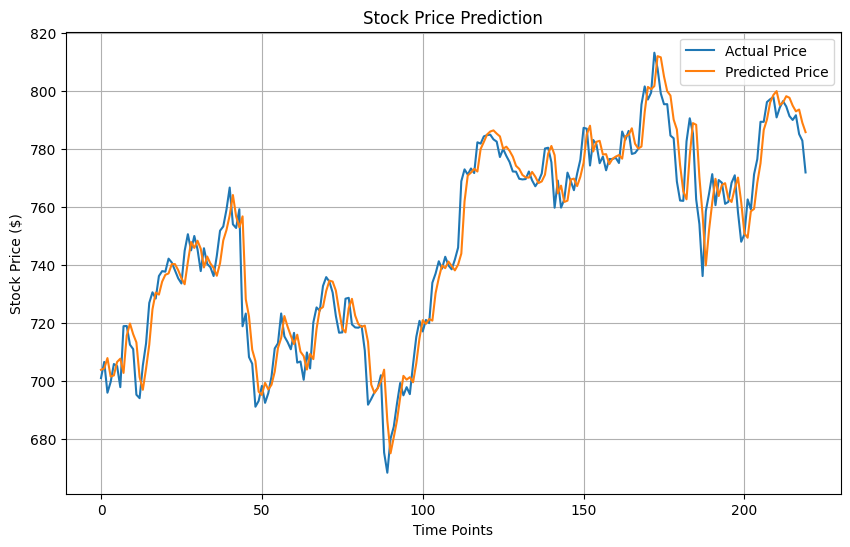

In [9]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Convert the test data to a PyTorch tensor
test_sequences_tensor = torch.FloatTensor(test_data_seq)

# No need to compute gradients (for faster computation and less memory usage)
with torch.no_grad():
    # Get predictions from the model for the test data
    predictions_tensor = model(test_sequences_tensor)

    # Flatten the predictions and convert to a NumPy array
    predictions_array = predictions_tensor.numpy().flatten()

    # Inverse transform the scaled predictions to the original data scale
    predicted_stock_prices = scaler.inverse_transform(predictions_array.reshape(-1, 1)).flatten()

# Inverse transform the true labels to the original data scale
true_stock_prices = scaler.inverse_transform(test_labels_seq.numpy().reshape(-1, 1)).flatten()

# Plotting the actual vs predicted stock prices
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(true_stock_prices, label='Actual Price')  # Plot the actual stock prices
plt.plot(predicted_stock_prices, label='Predicted Price')  # Plot the predicted stock prices
plt.title('Stock Price Prediction')  # Set the title of the plot
plt.xlabel('Time Points')  # Label the x-axis
plt.ylabel('Stock Price ($)')  # Label the y-axis
plt.legend()  # Show the legend
plt.grid(True)  # Show a grid for better readability
plt.show()  # Display the plot


In this graph, the actual stock prices fluctuate between roughly $680 and $820. Around time point 100, both actual and predicted prices dip sharply, with the actual hitting near $680 and the predicted slightly above that. The closest convergence occurs near time point 125, with both lines nearly overlapping around the $720 mark. Discrepancies are visible, for example, around time point 175, where the actual price peaks above $800 while the predicted peaks just below. The overall trends are similar, yet the model occasionally either overestimates or underestimates the actual price, especially at sharp turning points in the market.

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(true_stock_prices, predicted_stock_prices)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate the Root Mean Squared Error (RMSE)
rmse = mean_squared_error(true_stock_prices, predicted_stock_prices, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(true_stock_prices, predicted_stock_prices)
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 72.39654541015625
Root Mean Squared Error (RMSE): 8.508615493774414
Mean Absolute Error (MAE): 6.326748847961426


The Mean Squared Error (MSE) of approximately 72.40 indicates that, on average, the squares of the errors (the differences between the predicted and actual values) are relatively low. However, squaring the errors tends to amplify the impact of larger mistakes made by the model. The Root Mean Squared Error (RMSE), at about 8.51, provides a more interpretable measure as it is in the same units as the stock price, suggesting that the model's predictions are, on average, within $8.51 of the actual stock prices. Lastly, the Mean Absolute Error (MAE) of roughly 6.33 is a clear indicator of average prediction error, demonstrating that the model's typical deviation from the true values is about $6.33. Together, these metrics suggest your model has a moderate level of accuracy, with some room for improvement, especially in handling outliers or volatile market movements.